In [1]:
###R Code for Mixed-Effects Modeling###

#Required packages
library(dplyr)
library(ggplot2)
library(mgcv)
library(purrr)
library(tidyr)
library(MASS)
library(gratia)

#Read data from Individual_subj_models.ipnyb
dat <- read.csv("IRT_cleaned_main.csv")
dat$subject <- factor(dat$subject)

# Create scaled IRT1c and IRT2c variables
dat$IRT1C_std <- scale(dat$IRT1C)
dat$IRT2C_std <- scale(dat$IRT2C)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select





Family: gaussian 
Link function: identity 

Formula:
IRT_bx ~ s(OutputPosition, k = 5) + s(total_recall, k = 5) + 
    ti(OutputPosition, total_recall) + abs_lag_ln_std + SemanticSimC_std + 
    ti(abs_lag_ln_std, SemanticSimC_std) + s(IRT1C, k = 3) + 
    s(IRT2C, k = 3)

Parametric coefficients:
                   Estimate Std. Error  t value Pr(>|t|)    
(Intercept)       0.3229346  0.0604374    5.343 9.13e-08 ***
abs_lag_ln_std    0.2611478  0.0009813  266.128  < 2e-16 ***
SemanticSimC_std -0.1330527  0.0009634 -138.105  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                                       edf Ref.df      F p-value    
s(OutputPosition)                    3.965  3.993  320.4  <2e-16 ***
s(total_recall)                      3.570  3.879  204.3  <2e-16 ***
ti(OutputPosition,total_recall)     15.992 15.999  382.6  <2e-16 ***
ti(abs_lag_ln_std,SemanticSimC_std) 11.229 13.042  400.7  <2e-16 ***
s


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 15 iterations.
The RMS GCV score gradient at convergence was 4.375441e-08 .
The Hessian was not positive definite.
Model rank =  47 / 47 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                                       k'   edf k-index p-value  
s(OutputPosition)                    4.00  3.96    0.99    0.28  
s(total_recall)                      4.00  3.57    0.99    0.24  
ti(OutputPosition,total_recall)     16.00 15.99    1.02    0.99  
ti(abs_lag_ln_std,SemanticSimC_std) 16.00 11.23    0.98    0.09 .
s(IRT1C)                             2.00  2.00    0.99    0.24  
s(IRT2C)                             2.00  2.00    1.01    0.82  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


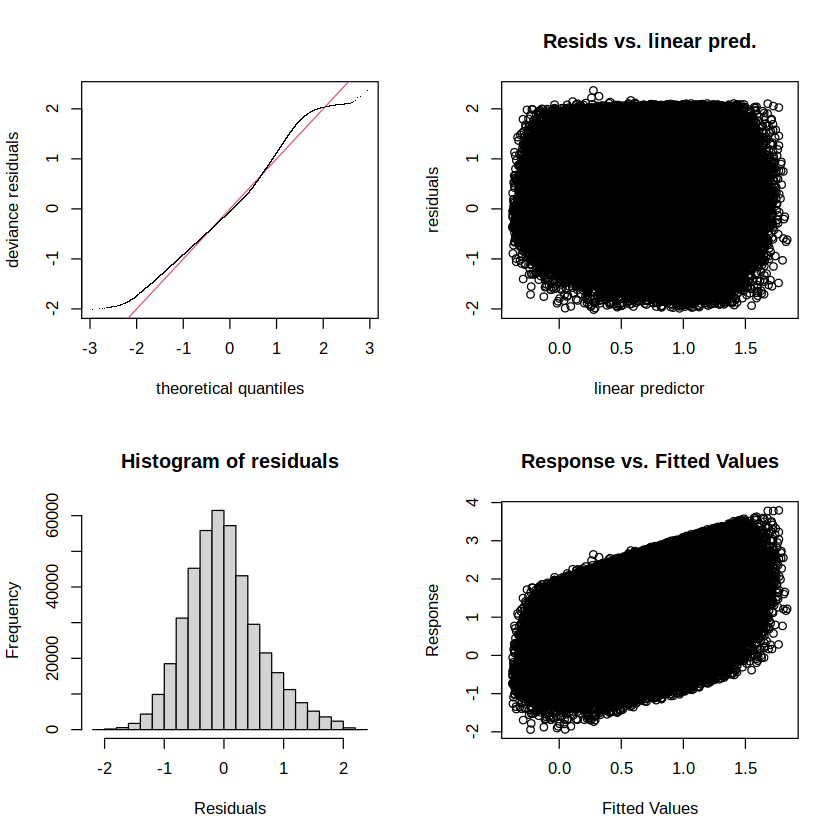

In [9]:
##Fixed effects only model fitted to the data without influential observations###

# Refit the GAM model without influential points and outliers
model_FE_cleaned <- gam(IRT_bx ~ s(OutputPosition, k=5) + s(total_recall, k=5) + 
                                ti(OutputPosition, total_recall) + abs_lag_ln_std + 
                                SemanticSimC_std + ti(abs_lag_ln_std, SemanticSimC_std) + 
                                s(IRT1C, k=3) + s(IRT2C, k=3),
                                data = dat)

# Check the summary of the cleaned model
summary(model_FE_cleaned)

# Diagnostic plots
par(mfrow = c(2, 2))
gam.check(model_FE_cleaned) #residuals much improved, but now the Hessian is not positive definite

# Plot the cleaned model
#plot(model_FE_cleaned)

In [8]:
# Check the levels of the subject factor
table(dat$subject)

# Check if any levels have only one observation
subject_counts <- table(dat$subject)
single_level_subjects <- names(subject_counts[subject_counts < 2])
print(single_level_subjects)


LTP093 LTP106 LTP115 LTP117 LTP122 LTP123 LTP133 LTP138 LTP187 LTP207 LTP210 
  3141   7154   5666   5575   8525   4073   3793   5201    954   1529   1034 
LTP228 LTP229 LTP236 LTP242 LTP246 LTP249 LTP250 LTP251 LTP258 LTP259 LTP260 
  1119   2015   6150     76   6802   3683   1623   4531   5092   3870   8211 
LTP265 LTP269 LTP273 LTP274 LTP278 LTP279 LTP280 LTP281 LTP283 LTP285 LTP287 
  6243   3974   1082    245   1137   4385   2138    131   5855   4178   1288 
LTP290 LTP293 LTP295 LTP296 LTP297 LTP298 LTP299 LTP300 LTP301 LTP302 LTP303 
  1660   4356   8353   3104   3129   1749   4071   1521    845   3575   6628 
LTP304 LTP305 LTP306 LTP307 LTP308 LTP309 LTP310 LTP311 LTP312 LTP313 LTP314 
  4232   1262   6385   6355    217     51   5307   5751   2482   1507    566 
LTP315 LTP316 LTP317 LTP318 LTP319 LTP320 LTP321 LTP322 LTP323 LTP324 LTP325 
   657   6259   2147   4527   1754     71   2495   4711   6275   3228   3206 
LTP326 LTP327 LTP328 LTP329 LTP330 LTP331 LTP334 LTP336 LTP337 

character(0)


In [ ]:
###Fit mixed-effects maximal allowable model with bam()###

#Through trial and error, discovered the IRT-1 and IRT-2 variables lead to non-convergence when fitted as smooth terms
# Create scaled IRT1c and IRT2c variables
dat$IRT1C_std <- scale(dat$IRT1C)
dat$IRT2C_std <- scale(dat$IRT2C)

# Set seed for reproducibility
set.seed(123)

model_ME <- bam(IRT_bx ~ s(OutputPosition, k=5) + s(total_recall, k=5) + ti(OutputPosition, total_recall) + 
                                       abs_lag_ln_std + SemanticSimC_std + 
                                       IRT1C_std + IRT2C_std + abs_lag_ln_std:SemanticSimC_std + 
                                       s(subject, bs = "re") + s(subject, abs_lag_ln_std, bs = "re") +
                 s(subject, SemanticSimC_std, bs="re") + s(subject, IRT1C_std, bs="re") + s(subject, IRT2C_std, bs="re") +
                 s(subject, OutputPosition, bs="re") + s(subject, total_recall, bs="re"),
                               data = dat)


Family: gaussian 
Link function: identity 

Formula:
IRT_bx ~ s(OutputPosition, k = 5) + s(total_recall, k = 5) + 
    ti(OutputPosition, total_recall) + abs_lag_ln_std + SemanticSimC_std + 
    IRT1C_std + IRT2C_std + abs_lag_ln_std:SemanticSimC_std + 
    s(subject, bs = "re") + s(subject, abs_lag_ln_std, bs = "re") + 
    s(subject, SemanticSimC_std, bs = "re") + s(subject, IRT1C_std, 
    bs = "re") + s(subject, IRT2C_std, bs = "re") + s(subject, 
    OutputPosition, bs = "re") + s(subject, total_recall, bs = "re")

Parametric coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      0.6037634  0.0404939   14.91   <2e-16 ***
abs_lag_ln_std                   0.2668548  0.0088932   30.01   <2e-16 ***
SemanticSimC_std                -0.1303557  0.0045411  -28.71   <2e-16 ***
IRT1C_std                        0.0431923  0.0038640   11.18   <2e-16 ***
IRT2C_std                        0.0302220  0.0026444   11.43   <2e-16 **


Method: fREML   Optimizer: perf newton
full convergence after 12 iterations.
Gradient range [-0.001211099,0.000472157]
(score 382976.4 & scale 0.3496121).
Hessian positive definite, eigenvalue range [0.9025576,213417.6].
Model rank =  919 / 919 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                                    k'    edf k-index p-value
s(OutputPosition)                 4.00   3.15    1.00    0.63
s(total_recall)                   4.00   3.00    1.01    0.77
ti(OutputPosition,total_recall)  16.00  14.48    1.00    0.34
s(subject)                      127.00 118.70      NA      NA
s(subject,abs_lag_ln_std)       127.00 121.31      NA      NA
s(subject,SemanticSimC_std)     127.00 112.65      NA      NA
s(subject,IRT1C_std)            127.00 108.16      NA      NA
s(subject,IRT2C_std)            127.00  94.36      NA      NA
s(subject,OutputPosition)       127.00 115.43      NA      NA
s(s

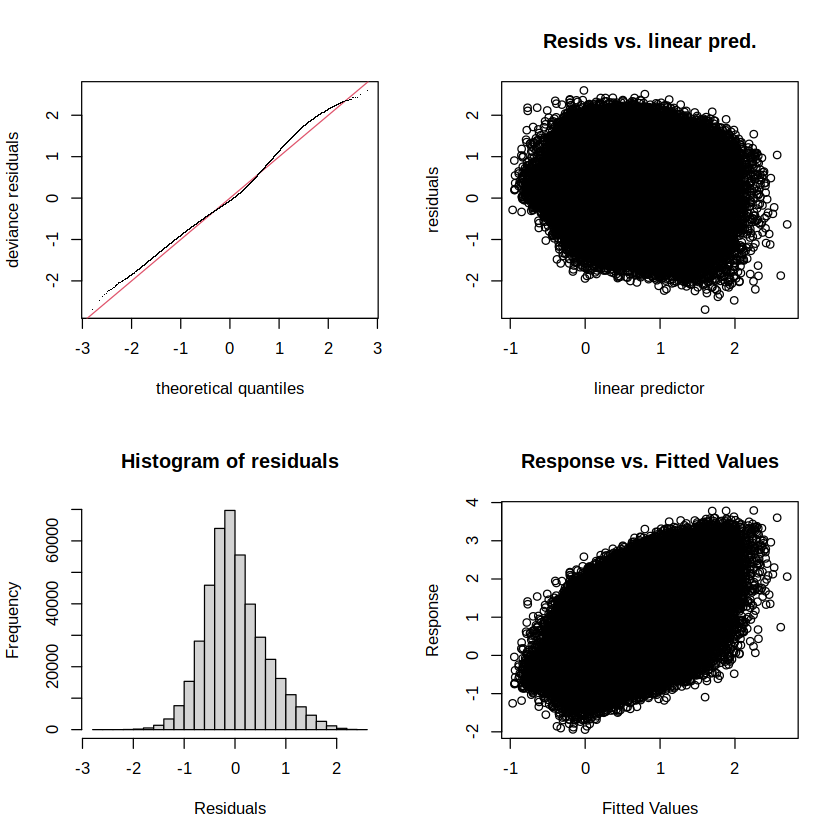

In [9]:
summary(model_ME)

# Diagnostic plots
par(mfrow = c(2, 2))
gam.check(model_ME)

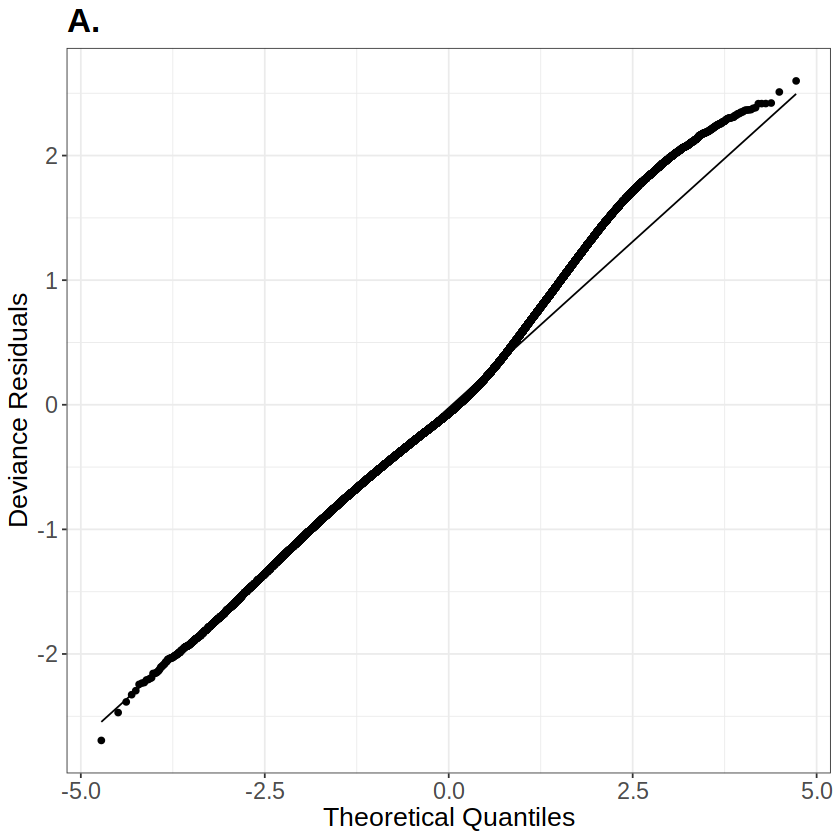

In [3]:
# Generate the Q-Q plot

qq_plot <- ggplot(data.frame(residuals = resid(model_ME)), aes(sample = residuals)) +
  stat_qq() +
  stat_qq_line() +
  labs(title = "A.", x = "Theoretical Quantiles", y = "Deviance Residuals") +
  theme_bw() +
  theme(
    plot.title = element_text(size = 20, face = "bold"),  # Title font size and bold
    axis.title = element_text(size = 16),                # Axis labels font size
    axis.text = element_text(size = 14)                  # Tick marks font size
  )

qq_plot

In [4]:
ggsave("resid_qq.png", plot = qq_plot, width = 5, height = 5, units = "in", dpi = 300)

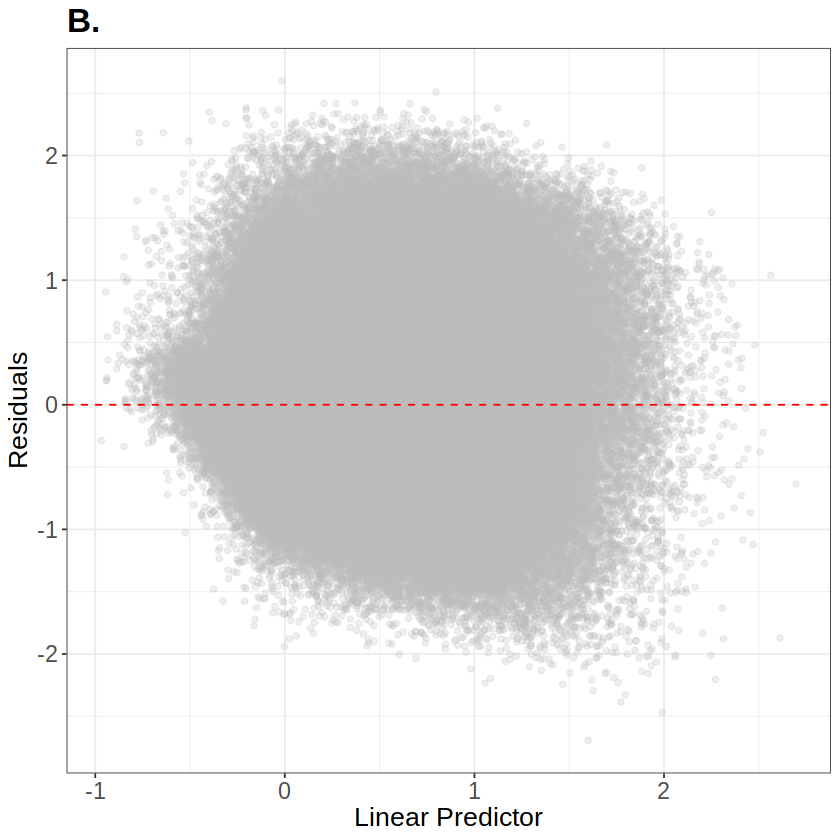

In [41]:
# Generate the Residuals vs Linear Predictor plot
residuals_vs_lp_plot <- ggplot(data.frame(fitted = fitted(model_ME), residuals = resid(model_ME)), 
                               aes(x = fitted, y = residuals)) +
  geom_point(color="gray",alpha = 0.25) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") +
  labs(title = "B.", x = "Linear Predictor", y = "Residuals") +
  theme_bw() +
  theme(
    plot.title = element_text(size = 20, face = "bold"),  # Title font size and bold
    axis.title = element_text(size = 16),                # Axis labels font size
    axis.text = element_text(size = 14)                  # Tick marks font size
  )

residuals_vs_lp_plot


In [42]:
ggsave("resid_lp.png", plot = residuals_vs_lp_plot, width = 5, height = 5, units = "in", dpi = 300)

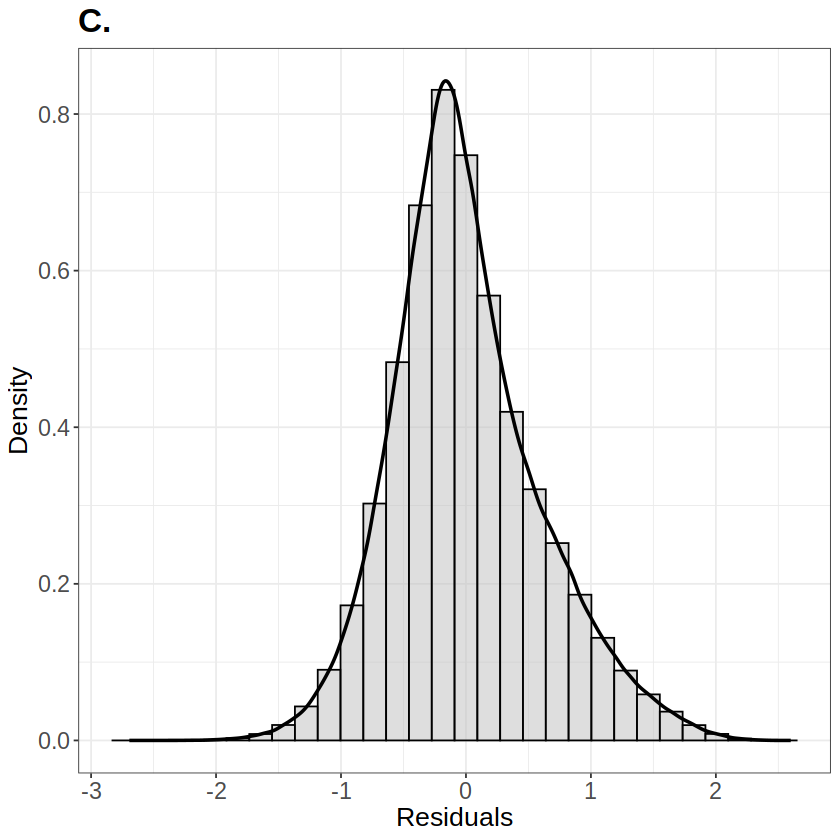

In [6]:
# Generate the Histogram of Residuals
histogram_plot <- ggplot(data.frame(residuals = resid(model_ME)), aes(x = residuals)) +
  geom_histogram(aes(y = ..density..), bins = 30, fill = "gray", alpha = 0.5, color="black") +
  geom_density(color = "black", size = 1) +
  labs(title = "C.", x = "Residuals", y = "Density") +
  theme_bw() +
  theme(
    plot.title = element_text(size = 20, face = "bold"),  # Title font size and bold
    axis.title = element_text(size = 16),                # Axis labels font size
    axis.text = element_text(size = 14)                  # Tick marks font size
  )

histogram_plot

In [9]:
ggsave("resid_histogram.png", plot = histogram_plot, width = 5, height = 5, units = "in", dpi = 300)

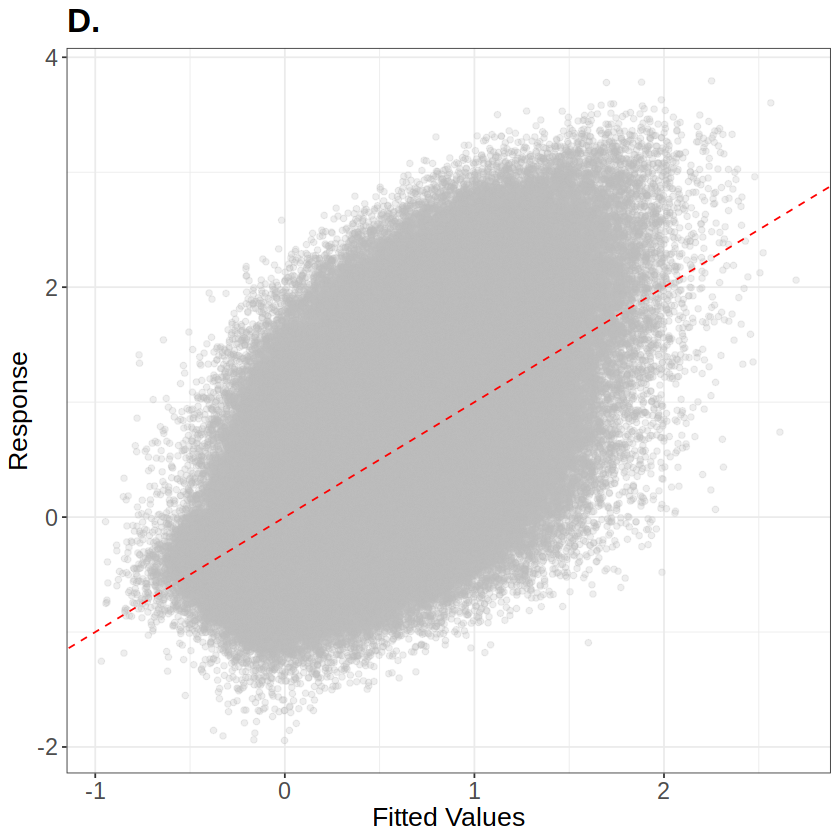

In [43]:
# Generate the Response vs Fitted Values plot
# Extract the response values from the original data frame used to fit the model
response_values <- model_ME$model[[1]]

response_vs_fitted_plot <- ggplot(data.frame(fitted = fitted(model_ME), response = response_values), 
                                  aes(x = fitted, y = response)) +
  geom_point(color="gray",alpha = 0.25) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "red") +
  labs(title = "D.", x = "Fitted Values", y = "Response") +
  theme_bw() +
  theme(
    plot.title = element_text(size = 20, face = "bold"),  # Title font size and bold
    axis.title = element_text(size = 16),                # Axis labels font size
    axis.text = element_text(size = 14)                  # Tick marks font size
  )

response_vs_fitted_plot

In [44]:
ggsave("response_vs_fitted.png", plot = response_vs_fitted_plot, width = 5, height = 5, units = "in", dpi = 300)

In [30]:
anova(model_ME)


Family: gaussian 
Link function: identity 

Formula:
IRT_bx ~ s(OutputPosition, k = 5) + s(total_recall, k = 5) + 
    ti(OutputPosition, total_recall) + abs_lag_ln_std + SemanticSimC_std + 
    IRT1C_std + IRT2C_std + abs_lag_ln_std:SemanticSimC_std + 
    s(subject, bs = "re") + s(subject, abs_lag_ln_std, bs = "re") + 
    s(subject, SemanticSimC_std, bs = "re") + s(subject, IRT1C_std, 
    bs = "re") + s(subject, IRT2C_std, bs = "re") + s(subject, 
    OutputPosition, bs = "re") + s(subject, total_recall, bs = "re")

Parametric Terms:
                                df      F p-value
abs_lag_ln_std                   1  900.4  <2e-16
SemanticSimC_std                 1  824.0  <2e-16
IRT1C_std                        1  124.9  <2e-16
IRT2C_std                        1  130.6  <2e-16
abs_lag_ln_std:SemanticSimC_std  1 2772.9  <2e-16

Approximate significance of smooth terms:
                                    edf  Ref.df         F  p-value
s(OutputPosition)                 3.150   3.3

In [3]:
#Variance/SD of smooths (include for the random effects)
variance_comp(model_ME)

component,variance,std_dev,lower_ci,upper_ci
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
s(OutputPosition),1.538505e-04,0.012403649,0.004621632,0.03328921
s(total_recall),4.394953e-05,0.006629444,0.002489939,0.01765085
"ti(OutputPosition,total_recall)1",4.635937e-02,0.215312256,0.111462715,0.41591816
"ti(OutputPosition,total_recall)2",2.297327e-01,0.479304374,0.220816250,1.04037943
s(subject),6.234807e-02,0.249695953,0.219238989,0.28438404
"s(subject,abs_lag_ln_std)",9.670261e-03,0.098337485,0.086555373,0.11172340
"s(subject,SemanticSimC_std)",2.341922e-03,0.048393410,0.042215078,0.05547596
"s(subject,IRT1C_std)",1.626871e-03,0.040334487,0.034981807,0.04650620
"s(subject,IRT2C_std)",6.646800e-04,0.025781388,0.021622457,0.03074026


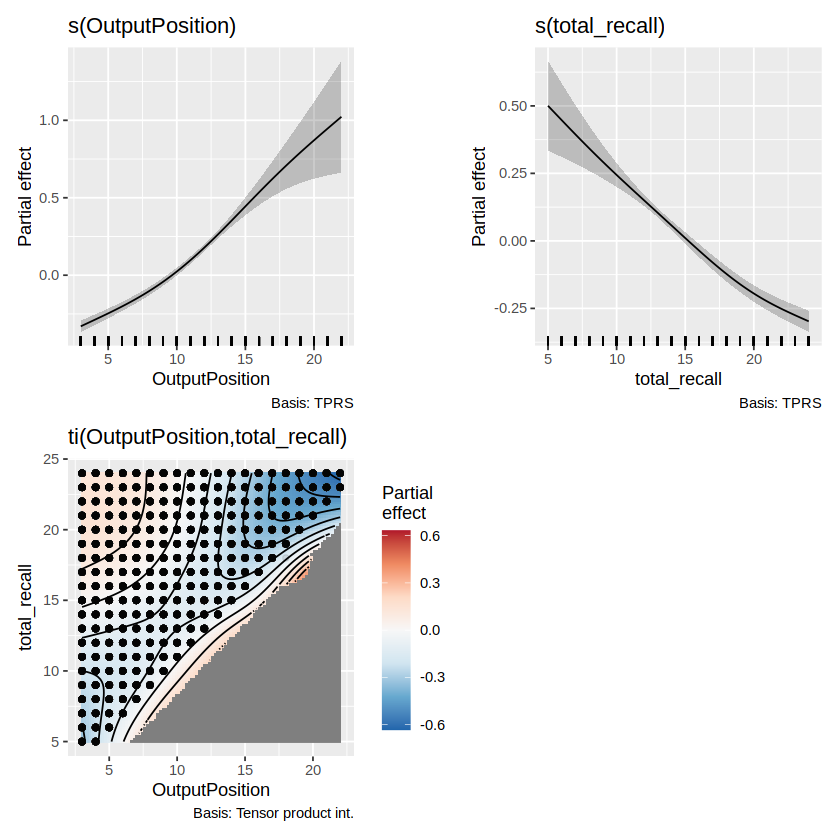

In [8]:
#Visualize the smooths for the fixed effects#

#library(gratia)

draw(model_ME, select=c("s(OutputPosition)", "s(total_recall)", "ti(OutputPosition,total_recall)"))

In [5]:
###Compute discrepancy values between model-predicted and observed IRTs for chunking analyses###

# Step 1: Obtain predicted values
predicted_values <- predict(model_ME3, newdata = dat, type = "response")

# Step 2: Calculate the discrepancy (predicted - observed)
discrepancy <- predicted_values - dat$IRT_bx
dat_new <- cbind(dat, discrepancy)

# Step 3: Create discrepancy_factor variable
dat_new$discrepancy_factor <- ifelse(dat_new$discrepancy < 0, "S", "F")

#write to csv and load it in if desired to skip above steps
write.csv(dat_new, "IRT_data_with_model_predictions.csv")

In [7]:
dat_new <- read.csv("IRT_data_with_model_predictions.csv") #save point, can load in data from here

In [21]:
####CHUNKING ANALYSES####

#COUNT ALL SFF, SSS, SFS, AND SSF COMBINATIONS#
#Counting occurs within a subject, within a session, within a list (trial)

# Function to count occurrences of specified combinations within a sequence
count_combinations <- function(sequence) {
  ff_count <- 0
  ss_count <- 0
  fs_count <- 0
  sf_count <- 0
  
  # Iterate through the sequence to count combinations
  for (i in 1:(length(sequence) - 2)) {
    if (!is.na(sequence[i]) && sequence[i] == "S" &&
        !is.na(sequence[i+1]) && !is.na(sequence[i+2])) {
      if (sequence[i+1] == "F" && sequence[i+2] == "F") {
        ff_count <- ff_count + 1
      } else if (sequence[i+1] == "S" && sequence[i+2] == "S") {
        ss_count <- ss_count + 1
      } else if (sequence[i+1] == "F" && sequence[i+2] == "S") {
        fs_count <- fs_count + 1
      } else if (sequence[i+1] == "S" && sequence[i+2] == "F") {
        sf_count <- sf_count + 1
      }
    }
  }
  
  # Return counts
  return(c(FF = ff_count, SS = ss_count, FS = fs_count, SF = sf_count))
}

# Function to count occurrences of specified combinations for each subject, session, and trial
count_combinations_by_subject <- function(df) {
  # Initialize a list to store counts for each subject
  subject_counts <- list()
  
  # Split the data frame by subject, session, and trial
  split_df <- split(df, list(df$subject, df$session, df$trial), drop = TRUE)
  
  # Iterate over each subset
  for (split_key in names(split_df)) {
    trial_df <- split_df[[split_key]]
    subject <- unique(trial_df$subject)[1]
    
    sequence <- trial_df$discrepancy_factor
    sequence <- sequence[!is.na(sequence)]  # Remove NA values
    
    if (length(sequence) < 3) {
      combination_counts <- c(FF = 0, SS = 0, FS = 0, SF = 0)
    } else {
      combination_counts <- count_combinations(sequence)
    }
    
    if (is.null(subject_counts[[subject]])) {
      subject_counts[[subject]] <- combination_counts
    } else {
      subject_counts[[subject]] <- subject_counts[[subject]] + combination_counts
    }
  }
  
  # Convert the list of counts to a data frame
  result <- do.call(rbind, subject_counts)
  return(result)
}

# Count occurrences of specified combinations for each subject
subject_counts <- count_combinations_by_subject(dat_new)

# Display subject counts
print(subject_counts)


         FF   SS   FS  SF
LTP093  332  228  240 252
LTP106  842  539  571 612
LTP115  609  489  435 511
LTP117  608  438  459 452
LTP122  967  914  847 891
LTP133  380  274  319 304
LTP138  562  391  436 439
LTP187   92   70   49  64
LTP207  150   80   89  88
LTP210   67   43   39  44
LTP228   73   37   51  59
LTP229  189  157  103 127
LTP236  648  528  502 572
LTP242    4    3    6   4
LTP246  750  614  396 537
LTP249  383  273  292 264
LTP250  149  112  121 127
LTP251  472  415  330 385
LTP258  560  386  409 401
LTP259  390  378  351 338
LTP260 1027  570  671 753
LTP265  702  496  535 556
LTP273   88   86   73  68
LTP274   17   22   17  11
LTP278   87   82   67  75
LTP279  435  441  306 362
LTP280  165  126  177 172
LTP281    8   12    7   6
LTP283  603  618  617 590
LTP285  426  300  347 354
LTP287   74   65   83  75
LTP290  180  104  127 116
LTP293  466  248  331 322
LTP295 1066  688  721 754
LTP297  297  263  243 273
LTP298  174  164  138 135
LTP299  401  313  336 343
LTP300  165 

In [24]:
#Convert to proportions#

# Compute row sums
row_sums <- rowSums(subject_counts)

# Compute proportions for each row
proportions <- subject_counts / row_sums

#omit NA values
proportions <- na.omit(proportions)

# Display the resulting proportions
head(proportions)

,FF,SS,FS,SF
LTP093,0.3155894,0.2167300,0.2281369,0.2395437
LTP106,0.3283931,0.2102184,0.2226989,0.2386895
LTP115,0.2979452,0.2392368,0.2128180,0.2500000
LTP117,0.3106796,0.2238120,0.2345427,0.2309658
LTP122,0.2672009,0.2525560,0.2340426,0.2462006
LTP133,0.2975724,0.2145654,0.2498042,0.2380579


In [4]:
# Save the resulting proportions matrix to a CSV file
#write.csv(proportions, file = "proportions_subject.csv", row.names = TRUE)
proportions <- read.csv("proportions_subject.csv") #can load in here to skip the above steps
proportions <- proportions[,-1] #remove first column

In [25]:
##Test which combinations exceed chance (0.25)

# Number of comparisons (number of columns in proportions matrix)
num_comparisons <- ncol(proportions)

#degrees of freedom
df <- nrow(proportions) - 1

# Set the desired alpha level for controlling the family-wise error rate
alpha <- 0.05

# Bonferroni corrected alpha level
alpha_corrected <- alpha / num_comparisons

#t-test
t_statistic <- apply(proportions, 2, function(col) {
  t_test <- t.test(col, mu = 0.25, alternative = "greater")
  return(t_test$statistic)
})

# Perform statistical tests for each column
p_values <- apply(proportions, 2, function(col) {
  t_test <- t.test(col, mu = 0.25, alternative = "greater")
  return(t_test$p.value)
})

# Bonferroni corrected p-values
p_values_corrected <- p.adjust(p_values, method = "bonferroni")

# Significant tests (using Bonferroni corrected alpha)
significant_tests <- p_values_corrected < alpha_corrected

# Display results
results <- data.frame(
  Combination = colnames(proportions),
  T_stat = t_statistic,
  DF = df,
  P_Value = p_values,
  P_Value_Corrected = p_values_corrected,
  Significant = significant_tests
)

print(results)

   Combination    T_stat  DF      P_Value P_Value_Corrected Significant
FF          FF 14.162820 126 3.936830e-28      1.574732e-27        TRUE
SS          SS -3.089030 126 9.987644e-01      1.000000e+00       FALSE
FS          FS -5.160106 126 9.999995e-01      1.000000e+00       FALSE
SF          SF -7.043433 126 1.000000e+00      1.000000e+00       FALSE


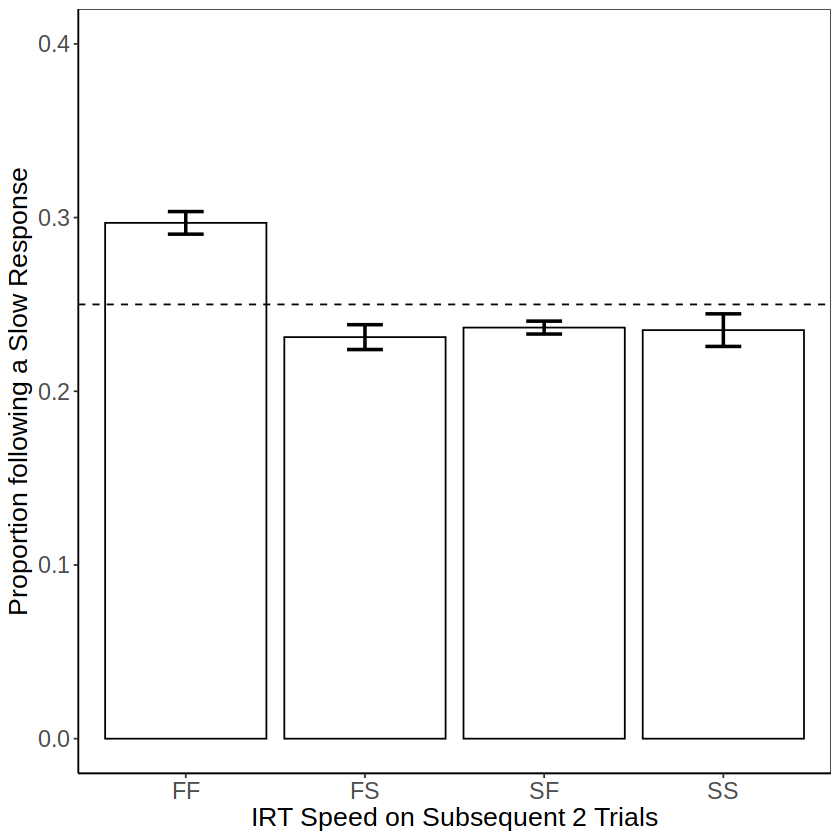

In [26]:
##Create a plot of the different combinations##

library(ggplot2)

# Calculate mean proportions across all subjects
mean_proportions <- colMeans(proportions)

# Convert mean proportions to a data frame
mean_proportions_df <- data.frame(Combination = names(mean_proportions), Mean_Proportion = mean_proportions)

# Calculate standard errors for each combination
se <- apply(proportions, 2, function(x) sqrt(var(x) / length(x)))

# Convert standard errors to a data frame
se_df <- data.frame(Combination = colnames(proportions), SE = se)

# Add mean proportions to se_df
se_df$Mean_Proportion <- mean_proportions_df$Mean_Proportion

# Create the bar plot with confidence intervals 
a <- ggplot(mean_proportions_df, aes(x = Combination, y = Mean_Proportion)) +
  geom_bar(stat = "identity", fill = NA, color = "black") +
  geom_errorbar(data = se_df, aes(ymin = Mean_Proportion - 1.96 * SE, ymax = Mean_Proportion + 1.96 * SE),
                width = 0.2, size = 1, color = "black") +
    ylim(0,0.4) + geom_hline(yintercept = 0.25, linetype = "dashed") +
  #labs(x = "IRT Speed on Subsequent 2 Trials", y = "Proportion following a Slow Response", tag="A.") +
    labs(x = "IRT Speed on Subsequent 2 Trials", y = "Proportion following a Slow Response") +
  theme_bw() + 
    theme(panel.grid.minor=element_blank(),
          panel.grid.major=element_blank(),
          axis.line=element_line(linewidth=0.5,linetype="solid",color="black"),
          axis.text=element_text(size=14), axis.title=element_text(size=16),
          #strip.text.x=element_text(size=14), strip.text.y=element_text(size=14),
         plot.tag.position=c(0.125, 0.975), 
         plot.tag = element_text(size = 18, face = "bold"))

a
ggsave("IRT_chunking.png", plot=a, w=6, h=6, dpi=300)

In [ ]:
###Create SFF sequences###

# Load required libraries
library(dplyr)

# Define input and output file paths
#input_file <- "/home1/nate.greene/CMLWorkshop/IRT/IRT_data_with_model_predictions.csv"
#output_dir <- "/home1/nate.greene/CMLWorkshop/IRT/"

# Load the data
#dat_new <- read.csv(input_file)

# Create discrepancy_factor variable
#dat_new$discrepancy_factor <- ifelse(dat_new$discrepancy < 0, "S", "F")

# Initialize an empty data frame to store the subset of data
subset_data <- data.frame()

# Split the data frame by subject, session, and trial
split_df <- split(dat_new, list(dat_new$subject, dat_new$session, dat_new$trial), drop = TRUE)

# Iterate over each subset (each subject-session-trial combination)
for (split_key in names(split_df)) {
  trial_df <- split_df[[split_key]]
  
  # Get indices of rows where discrepancy_factor is "S"
  s_indices <- which(trial_df$discrepancy_factor == "S")
  
  # Initialize a vector to store indices of rows to retain
  retain_indices <- c()
  
  # Iterate through each index where discrepancy_factor is "S"
  for (i in s_indices) {
    # Check if the next two rows have "F" and do not spill over
    if (i + 2 <= nrow(trial_df) &&  # Ensure we do not go out of bounds
        !any(is.na(trial_df$discrepancy_factor[(i + 1):(i + 2)])) &&  # Check for NA values
        all(trial_df$discrepancy_factor[(i + 1):(i + 2)] == "F")) {   # Check for "F" values
      # Add the current index and the indices of the next two rows to retain_indices
      retain_indices <- c(retain_indices, i:(i + 2))
    }
  }
  
  # Subset the current trial data using the retain_indices and append to subset_data
  subset_data <- rbind(subset_data, trial_df[retain_indices, ])
}

#write.csv(subset_data, file.path(output_dir, "subset_data.csv"))

In [2]:
#write.csv(subset_data, "SFF_sequences.csv")
subset_data <- read.csv("subset_data.csv")

In [4]:
####Here I calculate the serial position range of each of the items in an SFF sequence####
##This can provide insight into the temporal proximity of the items during their encoding##

# Initialize an empty vector to store the range of serialpos for each sequence
serialpos_range <- numeric()

# Iterate through each row of the data
for (i in 1:(nrow(subset_data) - 2)) {
  # Check if the current row is an "S" trial
  if (subset_data$discrepancy_factor[i] == "S") {
    # Extract the relevant subset of rows for the current "SFFF" sequence
    sequence_subset <- subset_data[i:(i + 2), ]
    
    # Print the serialpos values for the current sequence
    #cat("Serialpos values for sequence:", sequence_subset$serialpos, "\n")
    
    # Calculate the range of serialpos for the current sequence
    range_serialpos <- max(sequence_subset$serialpos) - min(sequence_subset$serialpos)
    
    # Store the range of serialpos for the current sequence
    serialpos_range <- c(serialpos_range, range_serialpos)
  }
}


In [5]:
# Compute the mean of serialpos_range
mean_serialpos_range <- mean(serialpos_range)

#Median of the serialpos_range
mdn_serialpos_range <- median(serialpos_range)

# Compute the standard deviation of serialpos_range
sd_serialpos_range <- sd(serialpos_range)

# Compute the range of serialpos_range
range_serialpos_range <- range(serialpos_range)

# Display the summary statistics
cat("Mean of serialpos_range:", mean_serialpos_range, "\n")
cat("Median of serialpos_range:", mdn_serialpos_range, "\n")
cat("Standard deviation of serialpos_range:", sd_serialpos_range, "\n")
cat("Range of serialpos_range:", range_serialpos_range[1], "to", range_serialpos_range[2], "\n")

Mean of serialpos_range: 6.670079 
Median of serialpos_range: 4 
Standard deviation of serialpos_range: 5.380977 
Range of serialpos_range: 2 to 23 


In [6]:
serial_pos_data <- data.frame(serialpos_range)
#head(serial_pos_data, n=10)

,serialpos_range
,<dbl>
1,16
2,2
3,9
4,13
5,7
6,6
7,4
8,10
9,6


In [16]:
save(serial_pos_data, file = "serial_pos_data.RData")
#serial_pos_data <-load("serial_pos_data.RData")

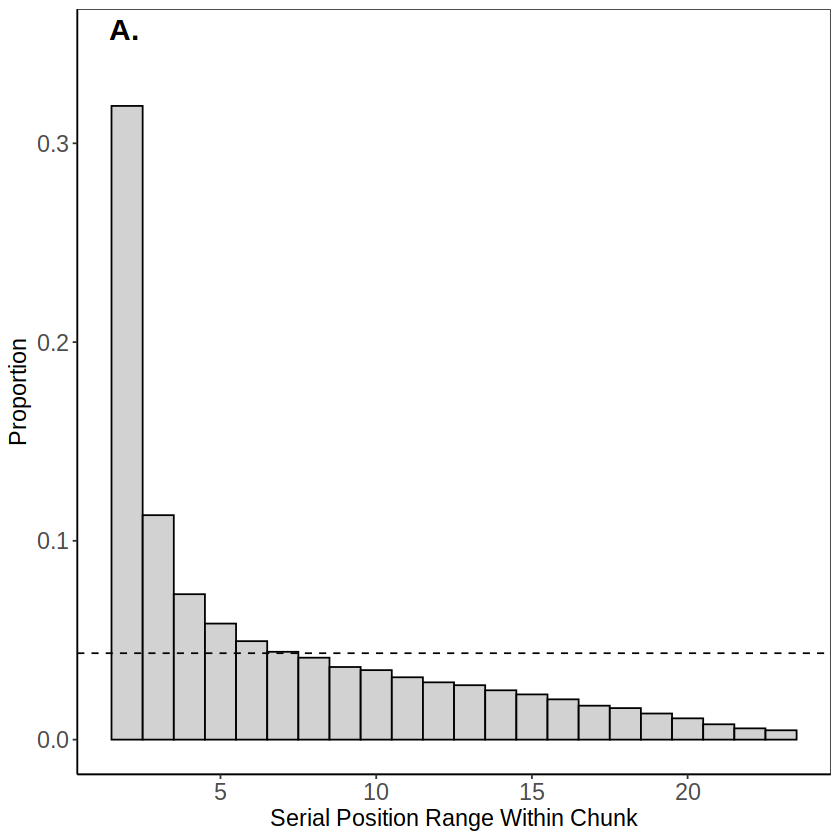

In [21]:
library(ggplot2)



# Create the histogram using ggplot
c <- ggplot(serial_pos_data, aes(x = serialpos_range)) +
  geom_histogram(aes(y = after_stat(density)), #y = ..density..), 
                 bins = 22, 
                 fill = "grey", 
                 color = "black", 
                 alpha = 0.7) +
  labs(x = "Serial Position Range Within Chunk",
       y = "Proportion", tag="A.") +
    ylim(0,0.35) +
    geom_hline(yintercept = (1/23), linetype = "dashed") + #add a line indicating chance probability
  theme_bw() + 
    theme(panel.grid.minor=element_blank(),
          panel.grid.major=element_blank(),
          axis.line=element_line(linewidth=0.5,linetype="solid",color="black"),
          axis.text=element_text(size=14), axis.title=element_text(size=14),
         plot.tag.position=c(0.14, 0.975), 
         plot.tag = element_text(size = 18, face = "bold"))

c
ggsave("IRT_chunks_sp_A.png", plot=c, w=5, h=4, dpi=300)

In [28]:
# Calculate the total number of sequences
total_sequences <- length(serialpos_range)

# Count the number of sequences with serialpos_range equal to 2
sequences_with_range_2 <- sum(serialpos_range == 2)
sequences_with_range_3 <- sum(serialpos_range == 2, serialpos_range == 3)
sequences_with_range_4 <- sum(serialpos_range == 2, serialpos_range == 3, serialpos_range == 4)

#proportion
sequences_with_range_2/total_sequences #0.347
sequences_with_range_3/total_sequences #0.468
sequences_with_range_4/total_sequences #0.546

[1] 0.3188067

[1] 0.4317277

[1] 0.5048935

In [25]:
#Find the minimum serialpos_range not exceeding change for SFF sequences#

# Calculate the total number of sequences
total_sequences <- length(serialpos_range)

# Initialize minimum serialpos_range
min_serialpos_range <- Inf

# Iterate through each possible serialpos_range
for (range in sort(unique(serialpos_range))) {
  
  # Count the number of sequences with serialpos_range equal to the current range
  sequences_with_current_range <- sum(serialpos_range == range)
  
  # Calculate the expected probability of having serialpos_range equal to the current range by chance
  expected_probability <- 1 / 22
  
  # Perform the binomial test
  p_value <- binom.test(sequences_with_current_range, total_sequences, expected_probability, alternative = "greater")$p.value
  
  # Check if the p-value is not significantly greater than 0.05
  if (p_value > 0.05) {
    min_serialpos_range <- range
    break  # Exit the loop once the minimum range is found
  }
}

# Display the minimum serialpos_range
print(min_serialpos_range)


[1] 7


In [ ]:
#Create SSS sequences#

# Load required libraries
library(dplyr)

# Define input and output file paths
#input_file <- "/home1/nate.greene/CMLWorkshop/IRT/IRT_data_with_model_predictions.csv"
#output_dir <- "/home1/nate.greene/CMLWorkshop/IRT/"

# Load the data
#dat_new <- read.csv(input_file)

# Create discrepancy_factor variable
#dat_new$discrepancy_factor <- ifelse(dat_new$discrepancy < 0, "S", "F")

# Initialize an empty data frame to store the subset of data
subset_data <- data.frame()

# Split the data frame by subject, session, and trial
split_df <- split(dat_new, list(dat_new$subject, dat_new$session, dat_new$trial), drop = TRUE)

# Iterate over each subset (each subject-session-trial combination)
for (split_key in names(split_df)) {
  trial_df <- split_df[[split_key]]
  
  # Get indices of rows where discrepancy_factor is "S"
  s_indices <- which(trial_df$discrepancy_factor == "S")
  
  # Initialize a vector to store indices of rows to retain
  retain_indices <- c()
  
  # Iterate through each index where discrepancy_factor is "S"
  for (i in s_indices) {
    # Check if the next two rows have "F" and do not spill over
    if (i + 2 <= nrow(trial_df) &&  # Ensure we do not go out of bounds
        !any(is.na(trial_df$discrepancy_factor[(i + 1):(i + 2)])) &&  # Check for NA values
        all(trial_df$discrepancy_factor[(i + 1):(i + 2)] == "S")) {   # Check for "S" values
      # Add the current index and the indices of the next two rows to retain_indices
      retain_indices <- c(retain_indices, i:(i + 2))
    }
  }
  
  # Subset the current trial data using the retain_indices and append to subset_data
  subset_data <- rbind(subset_data, trial_df[retain_indices, ])
}

write.csv(subset_data, file.path(output_dir, "subset_data2.csv"))


In [10]:
###Matched SSS sequences####
subset_data2 <- read.csv("subset_data2.csv")

In [12]:
# Initialize an empty vector to store the range of serialpos for each sequence
serialpos_range2 <- numeric()

# Iterate through each triad of rows
for (i in seq(1, nrow(subset_data2), by = 3)) {
  # Ensure there are at least 3 rows left
  if (i + 2 <= nrow(subset_data2)) {
    # Extract the relevant subset of rows for the current "SSS" sequence
    sequence_subset <- subset_data2[i:(i + 2), ]
    
    # Calculate the range of serialpos for the current sequence
    range_serialpos <- max(sequence_subset$serialpos) - min(sequence_subset$serialpos)
    
    # Store the range of serialpos for the current sequence
    serialpos_range2 <- c(serialpos_range2, range_serialpos)
  }
}

# Display the computed serialpos ranges
#print(serialpos_range2)


In [13]:
# Compute the mean of serialpos_range
mean_serialpos_range2 <- mean(serialpos_range2)

#Median of the serialpos_range
mdn_serialpos_range2 <- median(serialpos_range2)

# Compute the standard deviation of serialpos_range
sd_serialpos_range2 <- sd(serialpos_range2)

# Compute the range of serialpos_range
range_serialpos_range2 <- range(serialpos_range2)

# Display the summary statistics
cat("Mean of serialpos_range:", mean_serialpos_range2, "\n")
cat("Median of serialpos_range:", mdn_serialpos_range2, "\n")
cat("Standard deviation of serialpos_range:", sd_serialpos_range2, "\n")
cat("Range of serialpos_range:", range_serialpos_range2[1], "to", range_serialpos_range2[2], "\n")

Mean of serialpos_range: 6.777463 
Median of serialpos_range: 5 
Standard deviation of serialpos_range: 5.318909 
Range of serialpos_range: 2 to 23 


In [14]:
serial_pos_data2 <- data.frame(serialpos_range2)

In [15]:
save(serial_pos_data2, file = "serial_pos_data2.RData")
#serial_pos_data2 <- load("serial_pos_data2.RData")

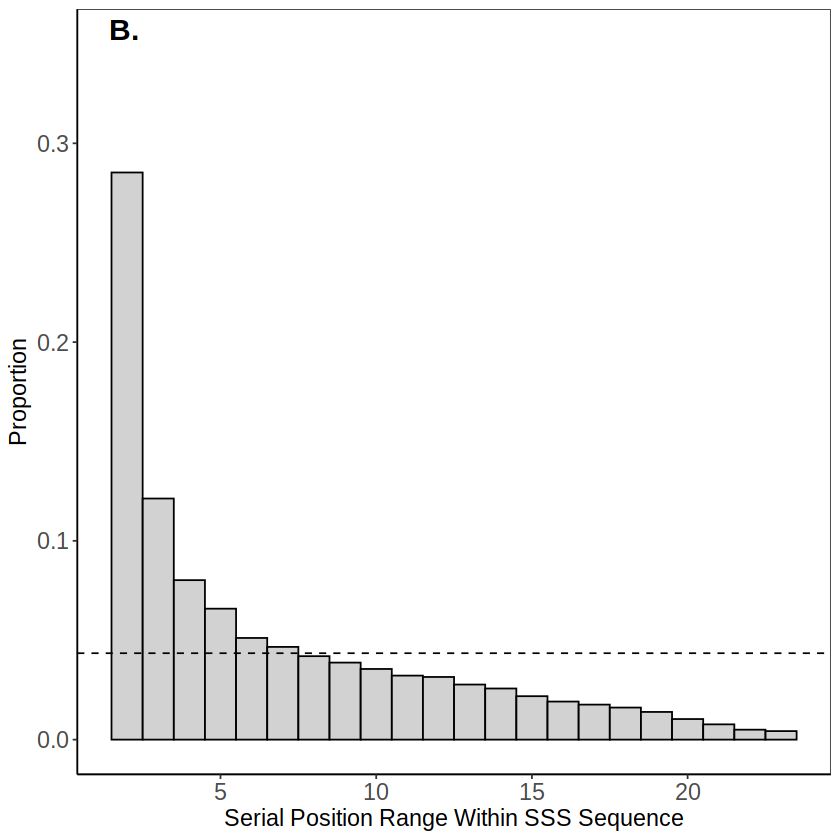

In [20]:
library(ggplot2)


# Create the histogram using ggplot
d <- ggplot(serial_pos_data2, aes(x = serialpos_range2)) +
  geom_histogram(aes(y = after_stat(density)), #y = ..density..), 
                 bins = 22, 
                 fill = "grey", 
                 color = "black", 
                 alpha = 0.7) +
  labs(x = "Serial Position Range Within SSS Sequence",
       y = "Proportion", tag="B.") +
    ylim(0,0.35) +
    geom_hline(yintercept = (1/23), linetype = "dashed") + #add a line indicating chance probability
  theme_bw() + 
    theme(panel.grid.minor=element_blank(),
          panel.grid.major=element_blank(),
          axis.line=element_line(linewidth=0.5,linetype="solid",color="black"),
          axis.text=element_text(size=14), axis.title=element_text(size=14),
         plot.tag.position=c(0.14, 0.975), 
         plot.tag = element_text(size = 18, face = "bold"))

d
ggsave("IRT_chunks_sp_B.png", plot=d, w=5, h=4, dpi=300)

In [26]:
#Find the minimum serialpos_range not exceeding change for SSS sequences#

# Calculate the total number of sequences
total_sequences <- length(serialpos_range2)

# Initialize minimum serialpos_range
min_serialpos_range <- Inf

# Iterate through each possible serialpos_range
for (range in sort(unique(serialpos_range2))) {
  
  # Count the number of sequences with serialpos_range equal to the current range
  sequences_with_current_range <- sum(serialpos_range2 == range)
  
  # Calculate the expected probability of having serialpos_range equal to the current range by chance
  expected_probability <- 1 / 22
  
  # Perform the binomial test
  p_value <- binom.test(sequences_with_current_range, total_sequences, expected_probability, alternative = "greater")$p.value
  
  # Check if the p-value is not significantly greater than 0.05
  if (p_value > 0.05) {
    min_serialpos_range <- range
    break  # Exit the loop once the minimum range is found
  }
}

# Display the minimum serialpos_range
print(min_serialpos_range)


[1] 7


In [29]:
####Calculate the average semantic similarity of each SFF sequence####

# Initialize an empty vector to store the average semantic similarity for each sequence
average_SemanticSim <- numeric()

# Iterate through each row of the data
for (i in 1:(nrow(subset_data) - 2)) {
  # Check if the current row is an "S" trial
  if (subset_data$discrepancy_factor[i] == "S") {
    # Extract the relevant subset of rows for the current "SFFF" sequence
    sequence_subset <- subset_data[i:(i + 2), ]
    
    # Print the serialpos values for the current sequence
    #cat("Serialpos values for sequence:", sequence_subset$serialpos, "\n")
    
    # Calculate the avg semantic sim of the subset
    avg_sequence_sem <- mean(sequence_subset$SemanticSim)
    
    # Store the avg semantic sim for the current sequence
    average_SemanticSim <- c(average_SemanticSim, avg_sequence_sem)
  }
}


In [30]:
mean(average_SemanticSim)
sd(average_SemanticSim)

[1] 0.1597772

[1] 0.08812607

In [31]:
####Calculate the average semantic similarity of each SSSS sequence####

# Initialize an empty vector to store the average semantic similarity for each sequence
average_SemanticSim2 <- numeric()

# Iterate through each triad of rows
for (i in seq(1, nrow(subset_data2), by = 3)) {
  # Ensure there are at least 3 rows left
  if (i + 2 <= nrow(subset_data2)) {
    # Extract the relevant subset of rows for the current "SSS" sequence
    sequence_subset <- subset_data2[i:(i + 2), ]
    
    # Calculate the avg semantic sim of the subset
    avg_sequence_sem <- mean(sequence_subset$SemanticSim)
    
    # Store the avg semantic sim for the current sequence
    average_SemanticSim2 <- c(average_SemanticSim2, avg_sequence_sem)
  }
}


In [32]:
mean(average_SemanticSim2)
sd(average_SemanticSim2)

[1] 0.1640088

[1] 0.08929505

In [33]:
# Perform a t-test to compare the average SemanticSim of SFF sequences to SSS sequences
t_test_result <- t.test(average_SemanticSim, average_SemanticSim2)

# Print the results of the t-test
print(t_test_result) #semantic similarity of SSS sequences is actually significantly higher than SFF sequences!


	Welch Two Sample t-test

data:  average_SemanticSim and average_SemanticSim2
t = -6.8116, df = 79710, p-value = 9.723e-12
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.005449286 -0.003014013
sample estimates:
mean of x mean of y 
0.1597772 0.1640088 



In [ ]:
####Fit the model to each individual subject and extract beta###
# Load the data
dat <- read.csv("IRT_cleaned_main.csv")
dat$subject <- factor(dat$subject)

# Create scaled IRT1c and IRT2c variables
dat$IRT1C_std <- scale(dat$IRT1C)
dat$IRT2C_std <- scale(dat$IRT2C

In [11]:
library(mgcv)
library(purrr)

# Create a list to store the models and coefficients
subject_coefficients <- list()

# Loop over each subject
for (subj in unique(dat$subject)) {
  # Filter the data for the current subject
  subj_data <- dat[dat$subject == subj, ]
  
  # Fit the model to the current subject's data
  model <- gam(IRT_bx ~ s(OutputPosition, k=5) + s(total_recall, k=5) + 
                 ti(OutputPosition, total_recall) + abs_lag_ln_std + 
                 SemanticSimC_std + IRT1C_std + IRT2C_std + 
                 abs_lag_ln_std:SemanticSimC_std, data = subj_data)
  
  # Extract the beta coefficients for the specified terms
  coefs <- coef(model)[c("abs_lag_ln_std", "SemanticSimC_std", "IRT1C_std", "IRT2C_std", 
                         "abs_lag_ln_std:SemanticSimC_std")]
  
  # Store the coefficients in the list
  subject_coefficients[[as.character(subj)]] <- coefs
}

# Convert the list to a data frame
coefficients_df <- do.call(rbind, subject_coefficients)
coefficients_df <- as.data.frame(coefficients_df)
coefficients_df$subject <- rownames(coefficients_df)
rownames(coefficients_df) <- NULL


In [12]:
head(coefficients_df)

,abs_lag_ln_std,SemanticSimC_std,IRT1C_std,IRT2C_std,abs_lag_ln_std:SemanticSimC_std,subject
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.5927202,-0.06394345,-0.002269212,-0.016074169,-0.05125976,LTP093
2,0.2496926,-0.12608585,0.049478262,0.008495685,-0.07263005,LTP106
3,0.2406216,-0.15096142,0.067744744,0.025805445,-0.06525556,LTP115
4,0.3012691,-0.11661138,0.031466123,0.027277223,-0.07810445,LTP117
5,0.1887264,-0.12865916,0.017034740,0.015485981,-0.03913223,LTP122
6,0.2444862,-0.30523148,0.065930716,0.030527539,-0.05768369,LTP123


In [13]:
write.csv(coefficients_df, "individual_coefficients.csv")

In [17]:
library(tidyr)
library(ggplot2)

# Reshape the data to long format
coefficients_long <- coefficients_df %>%
  gather(key = "Predictor", value = "Beta", -subject)

# View the reshaped data
head(coefficients_long)


,subject,Predictor,Beta
,<chr>,<chr>,<dbl>
1,LTP093,abs_lag_ln_std,0.5927202
2,LTP106,abs_lag_ln_std,0.2496926
3,LTP115,abs_lag_ln_std,0.2406216
4,LTP117,abs_lag_ln_std,0.3012691
5,LTP122,abs_lag_ln_std,0.1887264
6,LTP123,abs_lag_ln_std,0.2444862


In [25]:
coefficients_long$Predictor <- recode(coefficients_long$Predictor,
                                      "abs_lag_ln_std" = "Lag",
                                      "SemanticSimC_std" = "SemanticSim",
                                      "IRT1C_std" = "IRT-1",
                                      "IRT2C_std" = "IRT-2",
                                      "abs_lag_ln_std:SemanticSimC_std" = "Lag x SemanticSim")

coefficients_long$Predictor <- factor(coefficients_long$Predictor, 
                                      levels = c("Lag", "SemanticSim", "Lag x SemanticSim", 
                                                 "IRT-1", "IRT-2"))



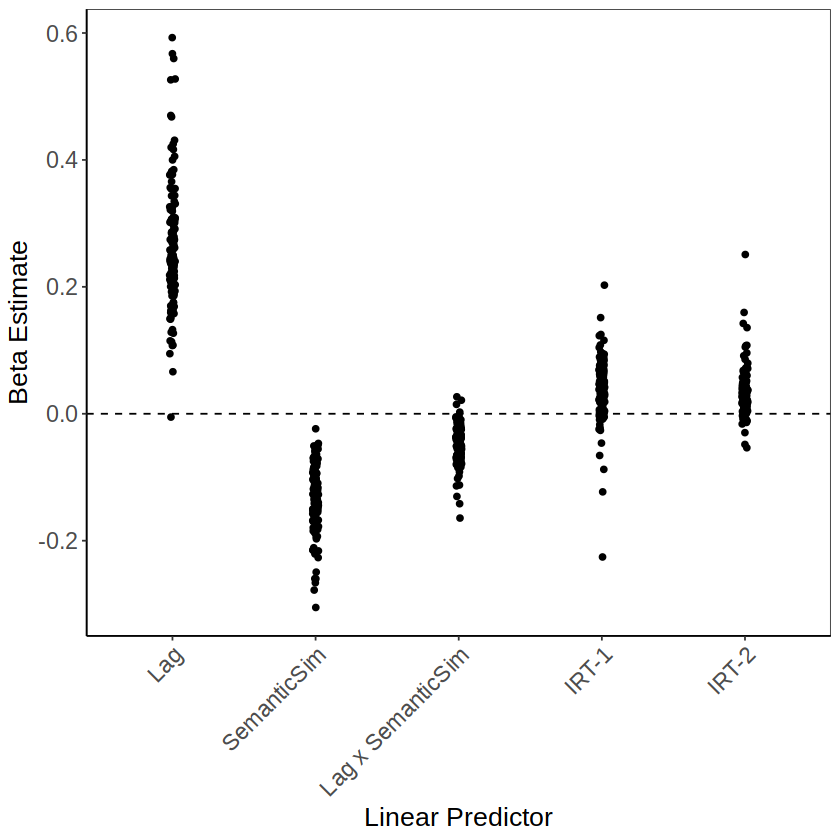

In [45]:
# Adjust the title with line breaks
g <- ggplot(coefficients_long, aes(x = Predictor, y = Beta)) +
  geom_point(color = "black", position = position_jitter(width = 0.02, height = 0)) +
  geom_hline(yintercept = 0, linetype = "dashed") +  # Add dashed horizontal line at y = 0
  theme_minimal() +
  labs(#title = "Individual Subject Effects of Parametric\nPredictors of IRTs",
       x = "Linear Predictor",
       y = "Beta Estimate") +
   theme_bw() + 
    theme(panel.grid.minor=element_blank(),
          panel.grid.major=element_blank(),
          axis.line=element_line(linewidth=0.5,linetype="solid",color="black"),
          #plot.title = element_text(size=18, hjust = 0.5)
          axis.text=element_text(size=14), axis.title=element_text(size=16),
          axis.text.x = element_text(angle = 45, hjust = 1),
         )

g

ggsave("IRT_individ_coeffs.png", plot=g, w=6, h=6, dpi=300)